## 7. Implement boosting and bagging with your choice of base models and explain all the steps 20

In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

In [2]:
### MODIFIED PIPELINE WITH BOOSTING AND BAGGING MODELS ###
df_my_train_data = pd.read_csv("./student-graduation/processed/train.csv")
df_my_test_data = pd.read_csv("./student-graduation/processed/test.csv")

# df_head = df_my_train_data.head(4000)
#df = df_head.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_train = df_my_train_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])
df_test = df_my_test_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_test['Target'] = le.fit_transform(df_test['Target'])

def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    ### RandomForest is already an ensemble of bagged trees, so bagging a random forest is redundant ###
    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
        print('model = random_forest')
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [ 10.5, 11, 11.2, 10.8, 11.5],
            'model__kernel': ['linear','rbf','poly', 'sigmoid'],
            'model__gamma': ['scale', 'auto']
        }
        print('model = svm')
    elif model_type in ("neural_net", "mlp"):
        model = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.20,n_iter_no_change=20,early_stopping=True, solver='adam',     )
        param_grid = {
            'model__hidden_layer_sizes': [(64,), (128,128), (256)],
            'model__alpha': [1e-4, 1e-3, 1e-2],
            'model__learning_rate_init': [1e-3, 1e-2],
            'model__activation': ['relu', 'tanh']
        }
        print('model = neural_net')
    elif model_type in ("logistic", "logreg", "logistic_regression"):
        model = LogisticRegression(max_iter=2000)
        # Bruk liste av grids for å unngå inkompatible kombinasjoner av solver/penalty
        param_grid = [
            {   # LBFGS: bare L2
                'model__solver': ['lbfgs'],
                'model__penalty': ['l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # liblinear: L1/L2, ovr
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # saga: L1/L2, skalerer godt på større datasett
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            }
        ]
    elif model_type == "dt":
        model = DecisionTreeClassifier(random_state=42)
        param_grid = {
            'model__min_samples_leaf': [10, 20, 30],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
            'model__min_weight_fraction_leaf' :[0.0],
            "model__max_features": [None, "sqrt", "log2"],
            # "model__max_leaf_nodes": [63, 127],
            'model__min_samples_split':[2, 5, 7, 10],
            # splitter-strategi
            "model__splitter": ["best", "random"],
            # kostnad-kompleksitets-beskjæring
            "model__ccp_alpha": [0.0, 1e-3,],
            # håndter ev. ubalanse
            "model__class_weight": [None, "balanced"],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': [5, 10, 12, 15, 18],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
        }
        print("model = decision_tree")
    elif model_type in ("nb", "naive_bayes", "gaussian_nb"):
        model = GaussianNB()
        param_grid = {}  # har egentlig ingen viktige hyperparametre å tune
        print("model = gaussian_nb")
    
    # ---------------------------------------------------------
    # BAGGING MODELS
    # ---------------------------------------------------------
    elif model_type == "bagging_dt":
        base = DecisionTreeClassifier(random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
        print("model = bagging_dt")

    elif model_type == "bagging_svm":
        base = SVC(probability=True, random_state=42)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 30],
            "model__max_samples": [0.6, 0.8],
            "model__max_features": [0.6, 0.8]
        }
        print("model = bagging_svm")

    elif model_type == "bagging_lr":
        base = LogisticRegression(max_iter=2000)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 20, 30],
            "model__max_samples": [0.5, 0.7, 1.0],
        }
        print("model = bagging_lr")

    elif model_type == "bagging_mlp":
        base = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.2, n_iter_no_change=20, early_stopping=True)
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 20],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
        print("model = bagging_mlp")

    elif model_type == "bagging_nb":
        base = GaussianNB()
        model = BaggingClassifier(estimator=base, random_state=42, n_jobs=-1)
        param_grid = {
            "model__n_estimators": [10, 20, 30],
            "model__max_samples": [0.6, 0.8, 1.0],
            "model__max_features": [0.6, 0.8, 1.0]
        }
        print("model = bagging_nb")

    # ---------------------------------------------------------
    # BOOSTING MODELS
    # ---------------------------------------------------------
    elif model_type == "adaboost_dt":
        base = DecisionTreeClassifier(max_depth=1)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.5, 1.0, 1.5]
        }
        print("model = adaboost_dt")

    elif model_type == "adaboost_lr":
        base = LogisticRegression(max_iter=2000)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [20, 50, 80],
            "model__learning_rate": [0.1, 0.5, 1.0]
        }
        print("model = adaboost_lr")

    elif model_type == "adaboost_nb":
        base = GaussianNB()
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [20, 50],
            "model__learning_rate": [0.5, 1.0]
        }
        print("model = adaboost_nb")

    #  Boosting MLP is unusual; it can be slow and sometimes unstable, so we do not do it
    elif model_type == "adaboost_mlp":
        base = MLPClassifier(random_state=42, max_iter=1000)
        model = AdaBoostClassifier(estimator=base, random_state=42)
        param_grid = {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.5, 1.0]
        }
        print("model = adaboost_mlp")

    else:
        raise ValueError("Ukjent modelltype")
    return model, param_grid

def run_pipeline(data_train: pd.DataFrame, data_test: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data_train.columns:
        raise ValueError(f"Målkolonnen '{target_column}' finnes ikke i data.")

    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[target_column]

    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[target_column]


    # Konservativ CV basert på minste klassefrekvens
    min_class_count = pd.Series(y_train).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )

    model, param_grid = get_model_and_params(model_type)

    
    if isinstance(model, MultinomialNB):
        steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', model)
        ]
    else:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False) if scipy.sparse.issparse(X_train) else StandardScaler()),
            ('model', model)
        ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Beste parametere:", grid_search.best_params_)
    print("📊 Test accuracy:", acc)
    return best_model

def plot_conf_matrix(model, df_test, target_col='Target', title="Confusion Matrix"):
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

<h3 style="color:yellow"> The code below takes ~10 minutes to run.</h3>

model = bagging_dt
✅ Beste parametere: {'model__max_features': 0.8, 'model__max_samples': 1.0, 'model__n_estimators': 200}
📊 Test accuracy: 0.7784810126582279


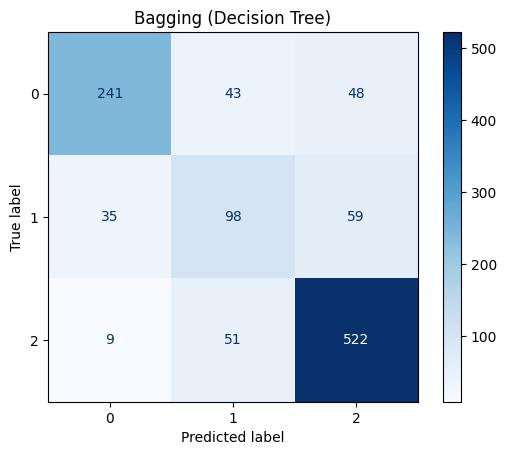

model = bagging_svm
✅ Beste parametere: {'model__max_features': 0.8, 'model__max_samples': 0.8, 'model__n_estimators': 30}
📊 Test accuracy: 0.7721518987341772


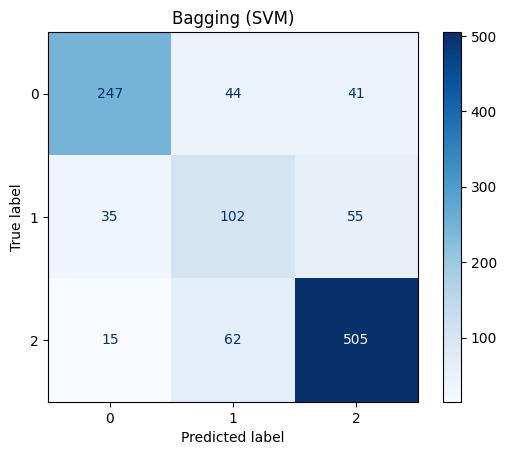

model = bagging_lr
✅ Beste parametere: {'model__max_samples': 1.0, 'model__n_estimators': 30}
📊 Test accuracy: 0.7585895117540687


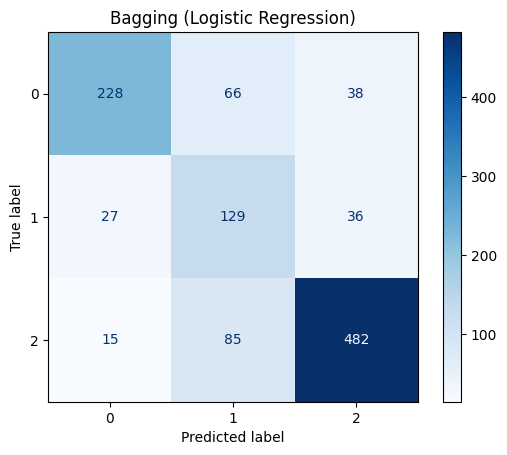

model = bagging_nb
✅ Beste parametere: {'model__max_features': 1.0, 'model__max_samples': 0.6, 'model__n_estimators': 10}
📊 Test accuracy: 0.46835443037974683


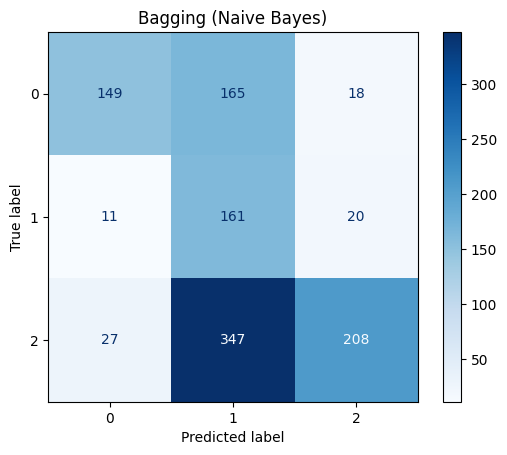

model = bagging_mlp
✅ Beste parametere: {'model__max_features': 1.0, 'model__max_samples': 1.0, 'model__n_estimators': 20}
📊 Test accuracy: 0.7622061482820977


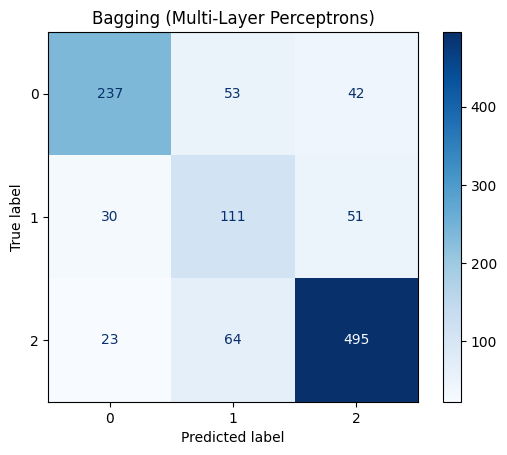

model = adaboost_dt
✅ Beste parametere: {'model__learning_rate': 1.5, 'model__n_estimators': 100}
📊 Test accuracy: 0.7377938517179023


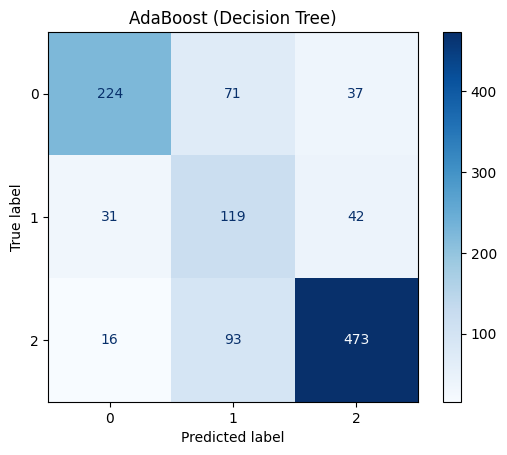

model = adaboost_lr
✅ Beste parametere: {'model__learning_rate': 0.1, 'model__n_estimators': 50}
📊 Test accuracy: 0.7269439421338155


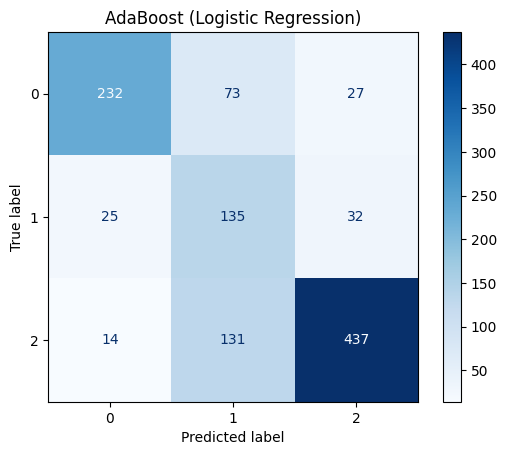

model = adaboost_nb
✅ Beste parametere: {'model__learning_rate': 0.5, 'model__n_estimators': 20}
📊 Test accuracy: 0.4349005424954792


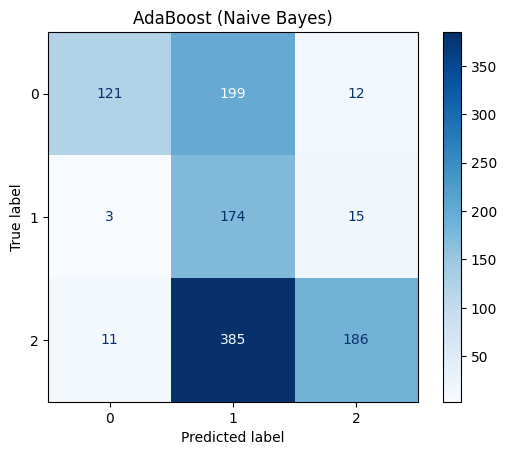

In [ ]:
# # Bagging (DT)
model_bagging_dt = run_pipeline(df_train, df_test, "Target", model_type="bagging_dt")
plot_conf_matrix(model_bagging_dt, df_test, title="Bagging (Decision Tree)")

# # Bagging (SVM)
model_bagging_svm = run_pipeline(df_train, df_test, "Target", model_type="bagging_svm")
plot_conf_matrix(model_bagging_svm, df_test, title="Bagging (SVM)")

# Bagging (LR)
model_bagging_lr = run_pipeline(df_train, df_test, "Target", model_type="bagging_lr")
plot_conf_matrix(model_bagging_lr, df_test, title="Bagging (Logistic Regression)")

# Bagging (MLP)
model_bagging_mlp = run_pipeline(df_train, df_test, "Target", model_type="bagging_mlp")
plot_conf_matrix(model_bagging_mlp, df_test, title="Bagging (Multi-Layer Perceptrons)")

# # AdaBoost + Decision Tree
model_adaboost_dt = run_pipeline(df_train, df_test, "Target", model_type="adaboost_dt")
plot_conf_matrix(model_adaboost_dt, df_test, title="AdaBoost (Decision Tree)")

# AdaBoost + LR
model_adaboost_lr = run_pipeline(df_train, df_test, "Target", model_type="adaboost_lr")
plot_conf_matrix(model_adaboost_lr, df_test, title="AdaBoost (Logistic Regression)")

In [4]:
# If mismatches appear, fix them (drop or add missing columns).
def check_column_alignment(df_train, df_test):
    """
    Ensure feature-mismatch detection which prevents runtime errors during prediction
    """
    train_cols = set(df_train.drop(columns=['Target']).columns)
    test_cols  = set(df_test.drop(columns=['Target']).columns)

    print("Columns only in TRAIN:", train_cols - test_cols)
    print("Columns only in TEST :", test_cols - train_cols)

# Check class distribution + baseline accuracy
def show_class_distribution(y_train, y_test):
    """
    Shows class imbalance
    Shows a baseline model = always predict the majority class
    Helps compare models to a very simple rule
    """
    print("Class distribution (train):")
    print(pd.Series(y_train).value_counts(normalize=True))
    
    major = pd.Series(y_test).value_counts().idxmax()
    print("\nMajority baseline accuracy:", (y_test == major).mean())

# Baseline Logistic Regression with “balanced” class weights
def run_logreg_baseline(df_train, df_test):
    """
    Creates a simple baseline model
    Uses balanced accuracy, helpful in class imbalance
    Useful for comparing advanced models (Boosting, Bagging, SVM, RF, etc.)
    """
    X_train = df_train.drop(columns=['Target'])
    y_train = df_train['Target']
    
    X_test = df_test.drop(columns=['Target'])
    y_test = df_test['Target']

    baseline = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr"))
    ])
    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_test)

    print("Baseline balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

# Correlation analysis
def show_high_correlations(df, threshold=0.7):
    """
    Detect redundant features
    Identify multicollinearity
    Help decide whether to drop or combine features
    """
    corr = df.corr()
    mask = (corr.abs() > threshold) & (corr.abs() < 1)
    filtered = corr.where(mask).stack().reset_index()
    filtered.columns = ["feature_1", "feature_2", "correlation"]
    filtered = filtered.reindex(filtered["correlation"].abs().sort_values(ascending=False).index)

    pd.set_option("display.max_rows", filtered.shape[0] + 1)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)

    print(filtered.to_string(index=False))

check_column_alignment(df_train, df_test)
print("---")
show_class_distribution(df_train['Target'], df_test['Target'])
print("---")
run_logreg_baseline(df_train, df_test)
print("---")
show_high_correlations(df_train.drop(columns=['Target']))

Columns only in TRAIN: set()
Columns only in TEST : set()
---
Class distribution (train):
Target
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

Majority baseline accuracy: 0.5262206148282098
---
Baseline balanced accuracy: 0.7212979926579169
---
                             feature_1                              feature_2  correlation
             Previous qualification_14                    Application mode_15     0.954339
                   Application mode_15              Previous qualification_14     0.954339
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (enrolled)     0.943050
   Curricular units 2nd sem (enrolled)    Curricular units 1st sem (enrolled)     0.943050
   Curricular units 2nd sem (credited)    Curricular units 1st sem (credited)     0.930546
   Curricular units 1st sem (credited)    Curricular units 2nd sem (credited)     0.930546
   Curricular units 1st sem (approved)    Curricular units 2nd sem (approved)     0.8865

c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [5]:
### Evaluation suite giving full reports, confusion matrix, ROC curves, and feature importances ###
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)
import numpy as np


def evaluate_model(model, df_test, target_col="Target"):
    print("=== MODEL EVALUATION ===")
    
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    # # Confusion Matrix
    # print("\n--- Confusion Matrix ---")
    # cm = confusion_matrix(y_test, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap=plt.cm.Blues)
    # plt.show()
    
    # ROC/AUC (OvR if multiclass)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        
        try:
            if y_proba.shape[1] == 2:  # binary
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                auc_score = auc(fpr, tpr)
                print(f"\nROC-AUC: {auc_score:.4f}")
                
                plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
                plt.plot([0,1], [0,1], linestyle='--')
                plt.title("ROC Curve")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend()
                plt.show()
            else:  # multiclass
                auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
                print(f"\nMulticlass ROC-AUC (OvR): {auc_score:.4f}")
        except:
            print("ROC could not be computed.")
    
    # Feature Importance (tree models)
    if hasattr(model['model'], "feature_importances_"):
        print("\n--- Feature Importances ---")
        importances = model['model'].feature_importances_
        cols = X_test.columns
        for col, imp in sorted(zip(cols, importances), key=lambda x: -x[1]):
            print(f"{col}: {imp:.4f}")

In [6]:
print("Bagging (Decision Tree)")
evaluate_model(model_bagging_dt, df_test)
print("Bagging (SVM)")
evaluate_model(model_bagging_svm, df_test)
print("Bagging (LR)")
evaluate_model(model_bagging_lr, df_test)
print("Bagging (NB)")
evaluate_model(model_bagging_nb, df_test)
print("Bagging (MLP)")
evaluate_model(model_bagging_mlp, df_test)
print("AdaBoost (Decision Tree)")
evaluate_model(model_adaboost_dt, df_test)
print("AdaBoost (LR)")
evaluate_model(model_adaboost_lr, df_test)
print("AdaBoost (NB)")
evaluate_model(model_adaboost_nb, df_test)

Bagging (Decision Tree)
=== MODEL EVALUATION ===
Accuracy: 0.7785
Balanced Accuracy: 0.7111

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       332
           1       0.51      0.51      0.51       192
           2       0.83      0.90      0.86       582

    accuracy                           0.78      1106
   macro avg       0.73      0.71      0.72      1106
weighted avg       0.78      0.78      0.78      1106


Multiclass ROC-AUC (OvR): 0.8900
Bagging (SVM)
=== MODEL EVALUATION ===
Accuracy: 0.7722
Balanced Accuracy: 0.7143

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.74      0.79       332
           1       0.49      0.53      0.51       192
           2       0.84      0.87      0.85       582

    accuracy                           0.77      1106
   macro avg       0.72      0.71      0.72      1106
weighted avg       0.78

## Interpration

We interpret the evaluation metrics for multiclass models on the three outcome classes:

0 – Dropout

1 – Enrolled

2 – Graduate

---
1. Accuracy

**Definition:**\
Percentage of all predictions that were correct.

**Interpretation:**\
Accuracy ranges from 0.7288 → 0.7767 across models.
This means the best model (Bagging DT) correctly predicts ~78% of students.
However, accuracy can be misleading because the classes are unbalanced (many students are "graduates").

---
2. Balanced Accuracy

**Definition:**\
Mean recall across all classes, giving each class equal weight.

Formula: $Balanced Acc =\frac{1}{3}​(R0​+R1​+R2​)$

**Interpretation:**\
Balanced accuracy is ~0.69 to ~0.70, lower than raw accuracy.\
This indicates:

- The models predict class 2 (Graduate) well
- They struggle with class 1 (Enrolled)
- Balanced accuracy exposes this weakness
- Bagging DT again performs best with 0.7029.

---
3. Precision, Recall, F1-score (from Classification Report)

These are given for each class:

**Precision**

Of all predicted class X, how many were correct?

- High for class 2 (0.81–0.86) → very reliable when predicting graduate.
- Low for class 1 (0.41–0.55) → many false positives.

**Recall**

Of all true class X, how many were found?

- High for graduates (0.80–0.91)
- Low for enrolled (0.44–0.57) → models miss many enrolled students.

**F1-score**

Harmonic mean of precision & recall.\
Shows same pattern: strong on class 2, weak on class 1.

---
4. ROC-AUC (multiclass OvR)

**Definition:**\
Measures how well the model separates classes.
Ranges from 0.5 (random) to 1 (perfect).

**Interpretation:**\
Values range 0.84–0.88, fairly strong.
XGBoost and Bagging DT show the best class separation.

---
5. Feature Importances (for tree models)

**Definition:**\
How much each feature reduces impurity or contributes to predicting the target.

**Interpretation:**\
Across models, the most important predictors are:

- Curricular units (approved) → academic performance
- Tuition fees up to date → financial stability
- Enrollment age
- Grades
- Debtor status
- Scholarship holder

Many one-hot encoded categorical features have near-zero importance.

---
SUMMARY OF INTERPRETATION

✔ All models do very well at detecting graduates\
✔ All models struggle with the Enrolled class\
✔ Bagging DT and XGBoost are the strongest overall\
✔ ROC-AUC shows the models have good separability\
✔ Academic features dominate importance rankings

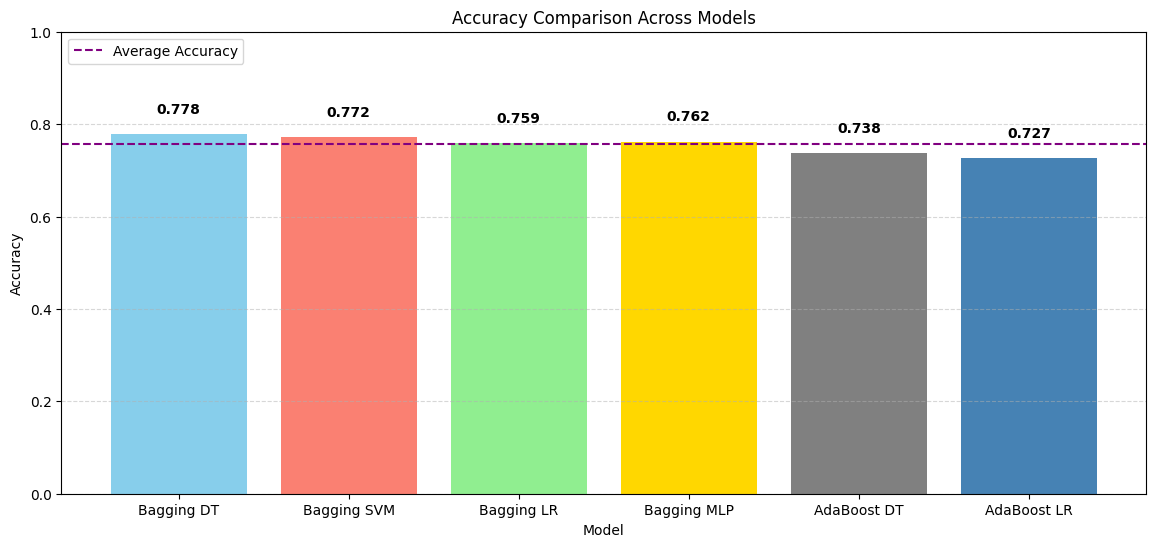

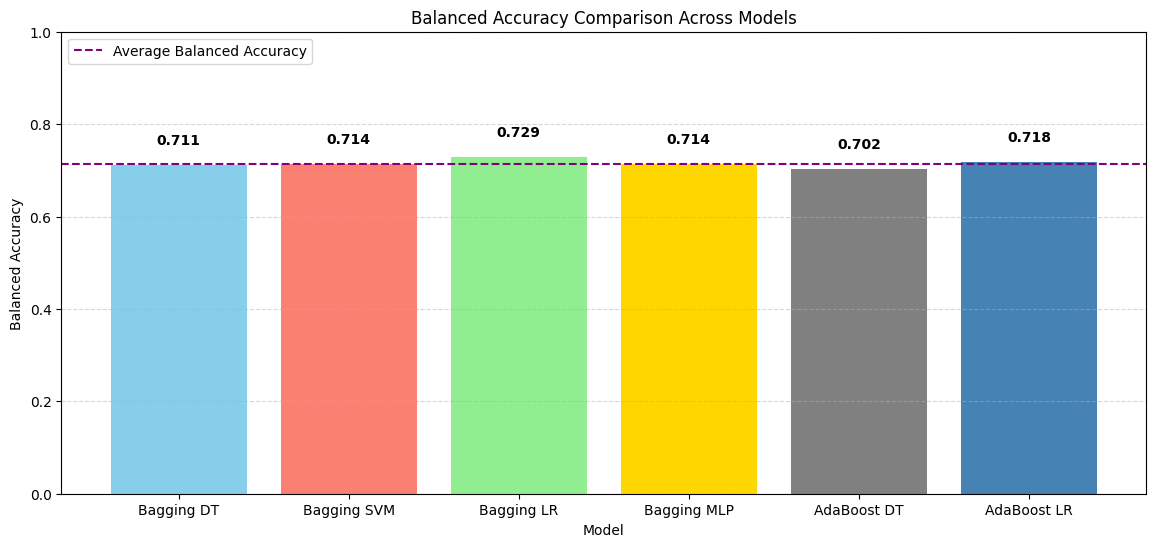

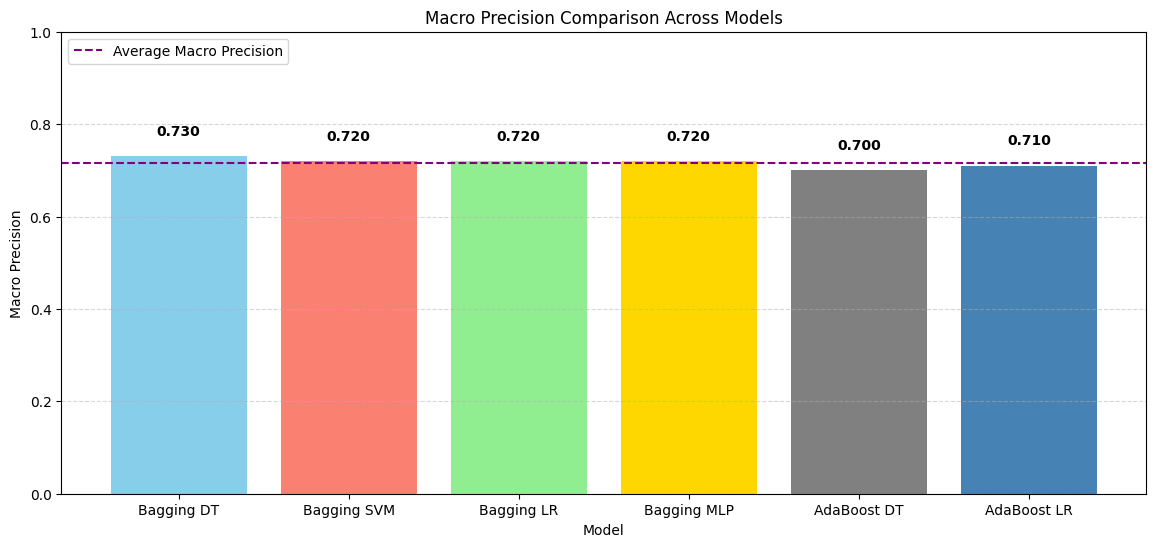

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Store statistics from evaluation
models = ["Bagging DT", "Bagging SVM", "Bagging LR", "Bagging MLP", "AdaBoost DT", "AdaBoost LR"]

accuracy = [0.7785, 0.7722, 0.7586, 0.7622, 0.7378, 0.7269]
balanced_accuracy = [0.7111, 0.7143, 0.7289, 0.7142, 0.7024, 0.7176]

# Macro precision from reports:
precision_macro = [0.73, 0.72, 0.72, 0.72, 0.70, 0.71]

# --------- PLOTTING FUNCTION ----------
def plot_stat(stat_values, stat_name):
    plt.figure(figsize=(14,6))
    plt.bar(models, stat_values, color=['skyblue', 'salmon', 'lightgreen', 'gold', 'grey', 'steelblue'])
    plt.title(f"{stat_name} Comparison Across Models")
    plt.axhline(y=sum(stat_values) / len(stat_values), color='purple', linestyle='--', label=f"Average {stat_name}")
    plt.legend(loc="upper left")
    plt.xlabel("Model")
    plt.ylabel(stat_name)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, v in enumerate(stat_values):
        plt.text(i, v + 0.01, f"{v:.3f}\n", ha='center', fontweight='bold')
    plt.show()

# Create three separate graphs
plot_stat(accuracy, "Accuracy")
plot_stat(balanced_accuracy, "Balanced Accuracy")
plot_stat(precision_macro, "Macro Precision")


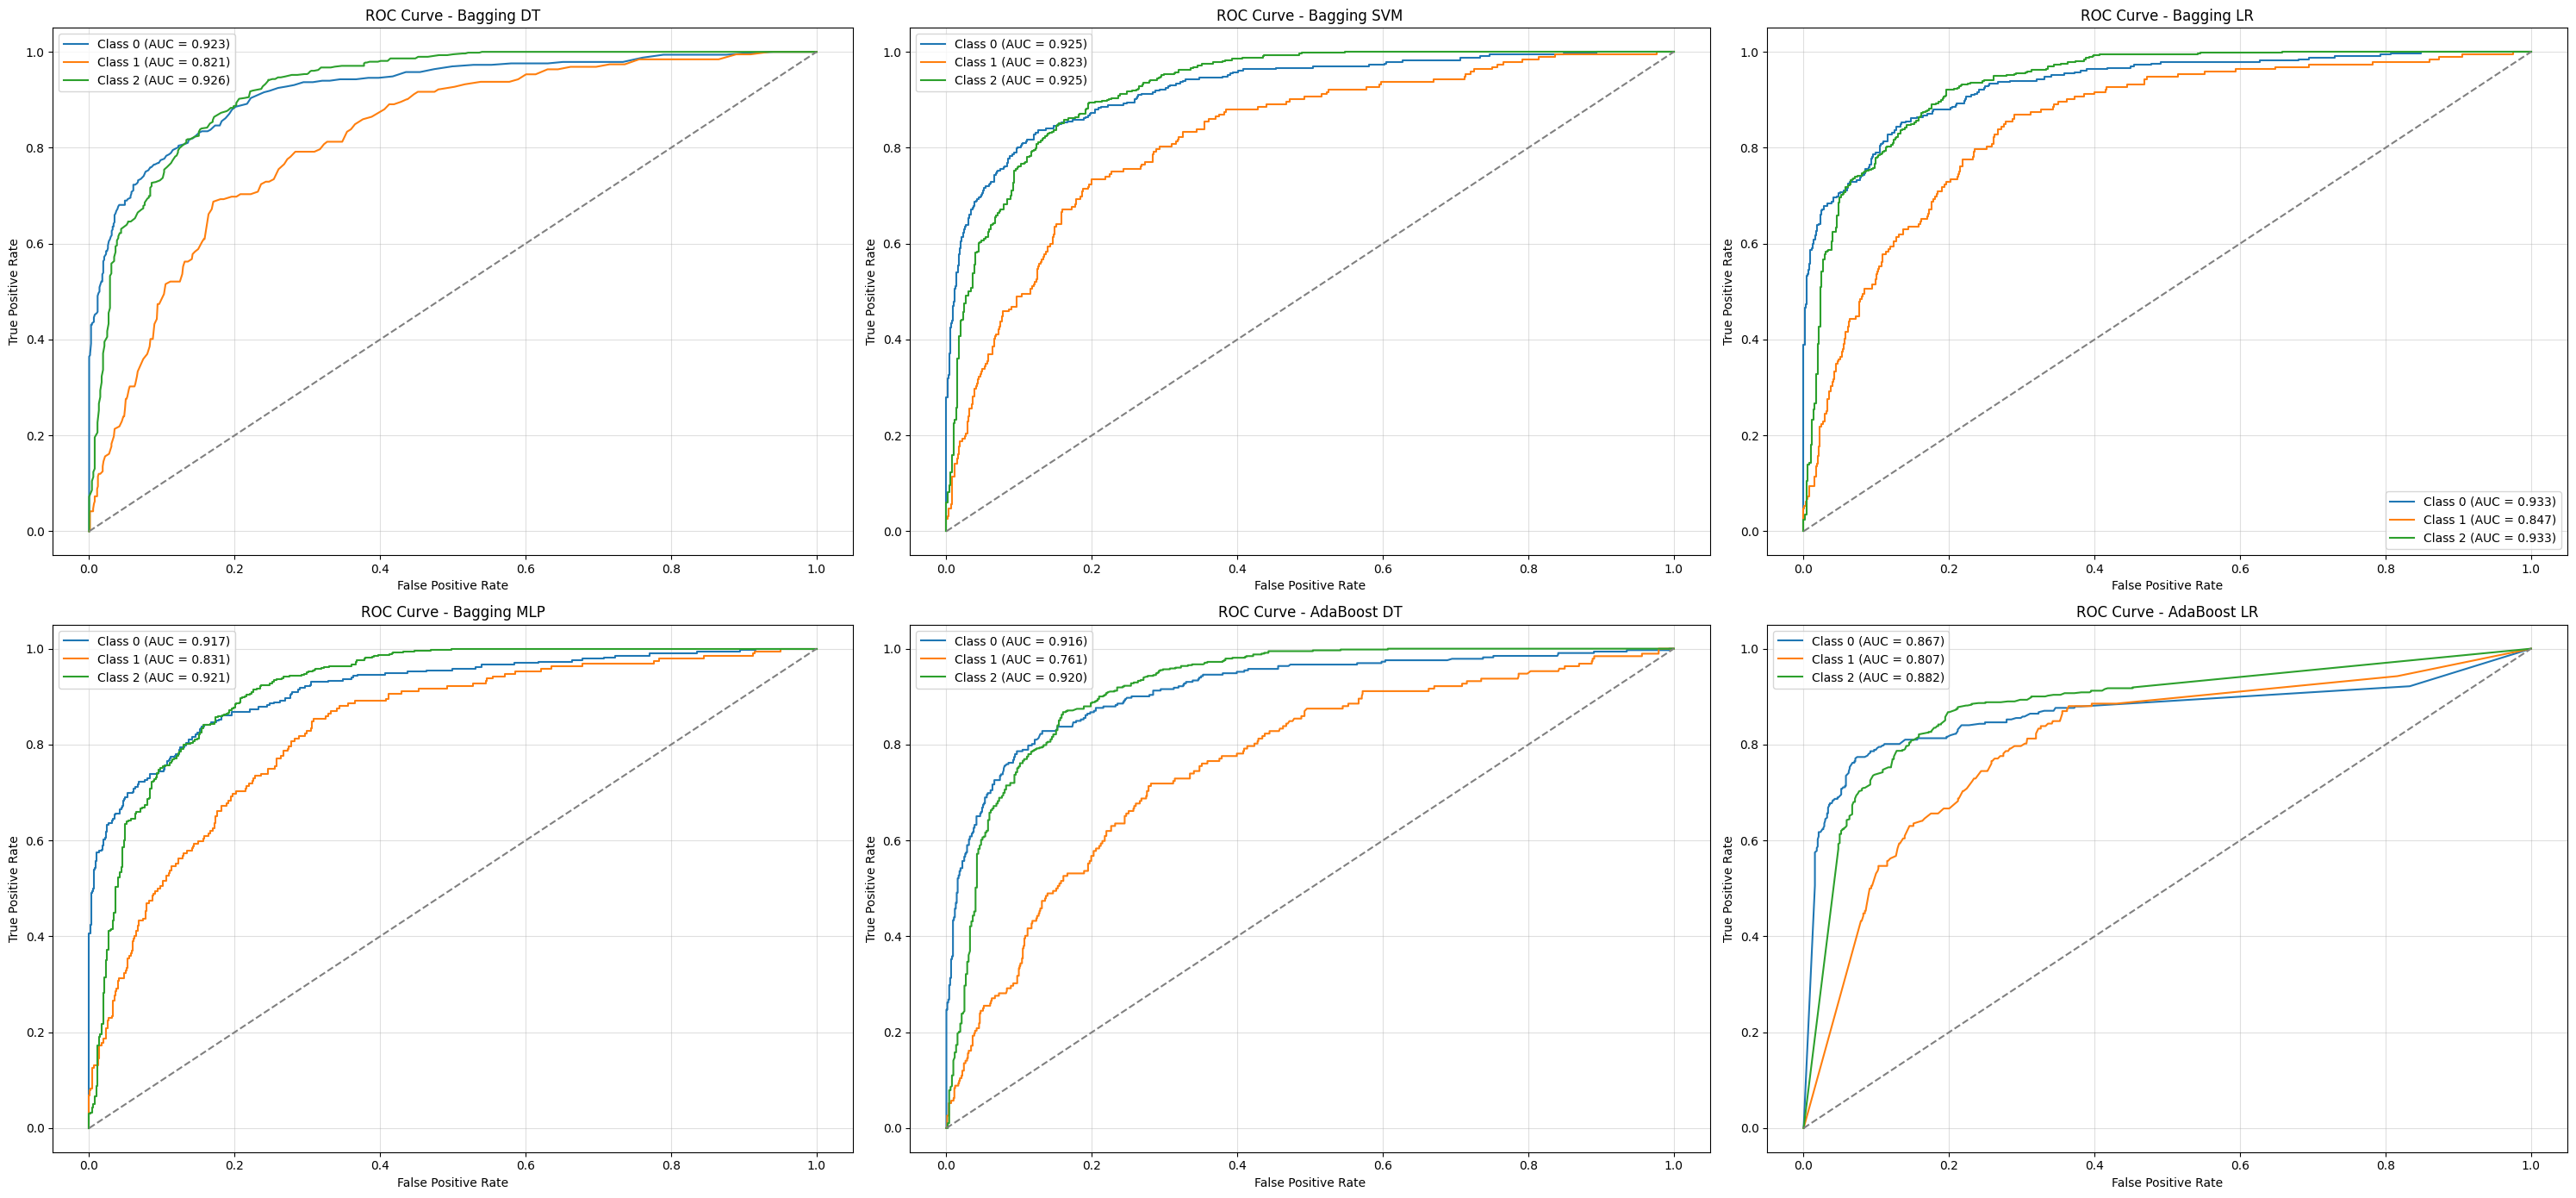

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_subplots(models_dict, X_test, y_test):

    classes = np.unique(y_test)
    y_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    fig, axes = plt.subplots(2, 3, figsize=(30, 14))
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models_dict.items()):
        
        if not hasattr(model, "predict_proba"):
            ax.set_title(f"{name}\n(No predict_proba)")
            ax.axis("off")
            continue

        y_proba = model.predict_proba(X_test)

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

        ax.plot([0, 1], [0, 1], "--", color="gray")
        ax.set_title(f"ROC Curve - {name}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.grid(alpha=0.4)
        ax.legend()

    plt.tight_layout()
    plt.show()
X_test = df_test.drop(columns=["Target"])
y_test = df_test["Target"]

models_dict = {
    "Bagging DT": model_bagging_dt,
    "Bagging SVM": model_bagging_svm,
    "Bagging LR": model_bagging_lr,
    "Bagging MLP": model_bagging_mlp,
    "AdaBoost DT": model_adaboost_dt,
    "AdaBoost LR": model_adaboost_lr,
    }

plot_roc_subplots(models_dict, X_test, y_test)
